In [16]:
my_set = {2,4,5,5}

In [23]:
df = df.set_index('IDpol')

In [ ]:
df.set_index(inplace=True)

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,AvgClaimAmount
IDpol,,,,,,,,,,,,,,,
1120377,1,0.22000,B,9,13,19.0,100,B2,Regular,93,R24,4075400.56,1.852455e+07,4.545455,4075400.56
110846,2,0.43000,C,6,13,20.0,100,B1,Regular,203,R24,1404185.52,3.265548e+06,4.651163,702092.76
2141337,1,0.32000,D,4,14,18.0,100,B2,Regular,863,R82,1301172.60,4.066164e+06,3.125000,1301172.60
3122016,1,0.91000,E,7,7,40.0,63,B11,Diesel,9307,R82,774411.50,8.510016e+05,1.098901,774411.50
2008127,3,0.36000,D,4,2,57.0,50,B4,Regular,1217,R82,399213.66,1.108927e+06,8.333333,133071.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114326,0,0.00274,E,4,0,54.0,50,B12,Regular,3317,R93,0.00,0.000000e+00,0.000000,0.00
6114327,0,0.00274,E,4,0,41.0,95,B12,Regular,9850,R11,0.00,0.000000e+00,0.000000,0.00
6114328,0,0.00274,D,6,2,45.0,50,B12,Diesel,1323,R82,0.00,0.000000e+00,0.000000,0.00


## NN Oefeningen GLM 1: De voorbereiding

*"Data is like garbage. You’d better know what you are going to do with it before you collect it." - Mark Twain* 

### Eind doel
Ons einddoel is om drie GLM-modellen te maken.
Elk model voorspelt één van de kerncomponenten van de schade:

Frequency (schadefrequentie),

Severity (schadeomvang) en

Pure Premium (verwachte schade per eenheid exposure).

In dit eerste notebook gaan we alle voorbereidende stappen doorlopen: 
1. Verkennen & splitsen van de data
2. Outliers/grote schades uitsluiten
3. Imputeren/droppen van missende waardes
4. Verwijderen niet-relevante kolommen
5. Categorische variabelen omzetten naar True/False kolommen (one-hot-encoding)
6. Kolommen groeperen in 'bins' (e.g. voor leeftijd) en dan ook True/False (one-hot-encoding)
7. Log-transformeer scheve waarden en schaal ze
8. Herhaal deze stappen voor je test-set

### Dataset 

Voor deze oefeningen wordt gebruik gemaakt van een dataset uit de `sklearn` package. Dit is een Franse dataset met claims van derden voor een autoverzekering. Ieder regel bevat informatie over één verzekerde.
Onze input data bevat de volgende informatie

| Kolom        | Beschrijving                                                                                   |
|--------------|-----------------------------------------------------------------------------------------------|
| IDpol        | Unieke identifier voor de polis                                                               |
| ClaimNb      | Aantal schadeclaims in de betreffende periode (handig voor frequentiemodel, Poisson/NB)     |
| Exposure     | Fractie van het jaar dat de polis actief was (kan gebruikt worden als offset in GLM)          |
| VehPower     | Vermogen van het voertuig                                                                     |
| VehAge       | Leeftijd van de auto in jaren                                                                 |
| Area         | Het gebied waar de auto geregistreerd staat                                                  |
| DrivAge      | Leeftijd van de bestuurder                                                                    |
| BonusMalus   | Representatie van de schadevrije jaren                                                       |
| Density      | Bevolkingsdichtheid van de woonomgeving                                                     |
| ClaimAmount  | Totale kosten van de claims (voor severity model, Gamma)                                      |



We maken in de oefeningen gebruk van de packages: *pandas*, *matplotlib* en *scikit-learn*. 



In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split


## 1: Inlezen, Verkennen & Splitsen

Voor het inlezen van de excel bestanden gebruiken we de pandas `pd.read_csv` functie. 
Is het pandas package nog helemaal nieuw voor je? Neem dan eerst de tijd om het oefen notebook *01_pandas_basis_dutch* te maken & door de NN basis opdrachten te lopen.

### Oefening 1.1 Inlezen
Lees het bestand `french_car_claim_set_big.csv` in. Bekijk de eerste 5 regels (met `df.head()`) om te zien of het bestand goed is ingelezen.

### Opdracht 1.2 - eerste verkenning
Gebruik de `df.shape` attribute en `df.describe()` method om de grootte en wat statistiek van de data te bekijken. 

met het input argument `include=object` voor de describe method kun je ook de niet-numerieke kolommen bekijken. 

Haal de volgende informatie uit je dataset:
1. Hoeveel rijen en kolommen heeft je dataset?

2. Wat is het gemiddelde Claim Amount?

3. Wat is de meest voorkomende Vehicle Brand?

4. Zie je onverwachte dingen in de data?


Met de GLM die we gaan maken willen we de Pure Premium modelleren. Dit is het verwachte totale schadebedrag per eenheid exposure. Deze waarde vormt
uiteindelijk de basis voor de premieberekening. Het Pure Premium is gedefinieerd als ClaimAmount/Exposure. 

Volgens kun je de Pure Premium in twee complonenten splitsen - Frequency en Severity -- omdat GLM-modellen vaak per onderdeel beter presteren. 
Door deze twee variabelen afzonderlijk te modelleren, krijgen we meer inzicht in waar variatie vandaan komt en kunnen we betere keuzes maken voor geschikte distributies.

Frequency is daarbij: het verwachte aantal claims per eenheid exposure (CliamNb/Exposure). We begrenzen daarbij extreme waarden om de invloed van uitschieters op het model te beperken met de waarde 10.

Severity (Average Claim Amount) is het gemiddelde schadebedrag per claim (ClaimAmount/ClaimNb). Deze kolom is nodig om het severity-gedeelte apart te kunnen modelleren met bijvoorbeeld een Gamma-verdeling. Door ClaimNb te vervangen door max(claims, 1) kun je deling door 0 voorkomen. 

### Opdracht 1.3: Kolommen toevoegen.

Voeg de kolommen `Frequency`, `Pure Premium` en `Severity` toe aan je dataframe. 
Clip Frequency op waarde 10 en neem bij Severity (ClaimAmount/ClaimNB) het maximum tussen ClaimNB en 1 om delen door 0 te voorkomen. 

Met de GLM die we gaan maken willen we de **Pure Premium** modelleren. Dit is het **verwachte totale schadebedrag per eenheid exposure**.  
Deze waarde vormt uiteindelijk de basis voor de **premieberekening**.  Het Pure Premium is gedefinieerd als:

`Pure Premium = ClaimAmount / Exposure`

---

Volgens de klassieke benadering kun je de Pure Premium opsplitsen in twee componenten: **Frequency** en **Severity**.  
GLM-modellen presteren vaak beter als ze per onderdeel worden gemodelleerd.  
Door deze twee variabelen afzonderlijk te modelleren:

- krijg je meer inzicht in waar variatie vandaan komt,  
- kun je betere keuzes maken voor geschikte distributies.  

**Frequency** is het **verwachte aantal claims per eenheid exposure**:

`Frequency = ClaimNb / Exposure`

- Extreme waarden worden begrensd op **10** om de invloed van uitschieters te beperken.

**Severity** (Average Claim Amount) is het **gemiddelde schadebedrag per claim**:

`Severity ClaimAmount / max(ClaimNb, 1)`

- Deze kolom wordt gebruikt om het **severity-gedeelte** apart te modelleren, bijvoorbeeld met een **Gamma-verdeling**.  
- Door `ClaimNb` te vervangen door `max(ClaimNb, 1)` voorkom je **delen door nul**.

---

### Opdracht 1.3: Kolommen toevoegen

Voeg de kolommen **`Frequency`**, **`PurePremium`** en **`Severity`** toe aan je dataframe.  

- **Frequency:** clip de waarden op maximaal 10.  
- **Severity:** bereken `ClaimAmount / max(ClaimNb, 1)` om deling door 0 te voorkomen.


### Opdracht 1.4 - Dataset splitsen in een train en een test set

Splits de dataset in een train_set en test_set (twee aparte dataframes) met de functie train_test_split() uit statsmodels. Reserveer 30 procent van de data voor de testset.

**Toelichting**

Het opsplitsen van je dataset is essentieel om te evalueren hoe goed je model presteert op data die het nog niet eerder heeft gezien. Het model wordt getraind op de train_set en vervolgens getest op de test_set. Dit voorkomt dat je model te optimistisch beoordeeld wordt doordat het alleen maar op bekende data getest wordt.

**Waarschuwing**

Let erop dat je alle bewerkingen die verband houden met modellering (zoals schalen, encoden, transformaties, etc. die we in dit notebook gaan doen) alleen op de trainingsset fit, en vervolgens toepast op de testset.

Als je deze stappen per ongeluk voor het splitsen uitvoert, of als je ze fit op de volledige dataset, introduceer je data leakage. Daardoor krijgt het model informatie uit de testset tijdens de training, wat leidt tot té goede prestaties die niet representatief zijn in de praktijk.

## STAP 2: Maak Datakwaliteit op orde

1.  outliers/extremen opsporen/foutieve waardes opsporen
2. missende waardes verwijderen, imputeren of een categorie 'onbekend' toevoegen. 

Uit de vorige opdracht weten we dat er in de kolom ClaimAmounts hoge extremen zitten en in de kolom DrivAge onmogelijke (negatieve) waardes. 
Deze gaan we aanpaken. We gaan ook checken of er missende waardes in de kolommen zitten.

### Opdracht 2.1 Uitsluiten Grote Schades.
1. Maak een boxplot van ClaimAmount. 
2. Maak een nieuw dataframe waarbij de grote schades worden geclipt op een bepaalde waarde. Over het algemeen zijn de waardes die buiten de 'snorharen' van de boxplot liggen de extremen - maar dit hangt natuurlijk af van de aard van het product. Voor deze analyse clippen we alle waardes boven de 20.000 euro op de waarde 20.000.
3. We clippen ook de waardes van Exposure en ClaimNb - zet deze waarde voor Exposure op 1 en voor ClaimNb op 4. 
4. Zet ClaimNb op 0 als de ClaimAmount 0 is - dan is later de frequency & severity makkelijker te vergelijken.


### Opdracht 2.2: Vervang incorrecte waarde in DrivAge met np.nan
Met `df.loc[:, 'col_name']` krijg je de data van één kolom. Deze kun je analyseren en bewerken. Er zijn al heel veel ingebouwde handige analyse opties, zoals
- .unique() --> Geef je unieke waardes uit de kolom terug
- .value_count() --> geef de unieke waardes en hun frequentie
- .fillna() --> vul de missende waardes op met een waarde 
- .sort_values() --> sorteer de kolom aan de hand van de waardes.
- En nog heel veel meer.


-- 
Opdracht: Bekijk welke leeftijden er in de dataset zitten. Vervang de incorrecte waardes met np.nan

### Opdracht 2.3: Missende waardes opvullen of verwijderen

De missende waardes moeten verwijderd worden uit de dataset voordat we een GLM kunnen maken. 
Om te zien welke kolommen waardes missen kun je de som van df.isna() gebruiken. 
Vul de missende leeftijd met de meest voorkomende leeftijd.



### Opdracht 2.4: Verwijderen van kolommen

Verwijder niet-relevante kolommen. We willen bijvoorbeeld geen voorspellers ontwikkelen aan de hand van het polis nummer. Verwijder dus de niet-relevante kolommen. 

# STAP 3: Datatypes omzetten naar numeriek

Alle datatypes moeten numeriek, of boolean zijn voor het werken met machine learning of GLMs. 
Check je datatypes met .dtypes(). Alles waar object staat moet worden omgezet, of verwijdert uit de dataset. 

We hebben nog een aantal categorische variabelen die we moeten omzetten naar numerieke waardes. Dat kan op twee manieren; met one-hot encoding of met ordinal enocding. 
Variabelen die je kunt ordenen (zoals bijv. energie niveau van een huis) zet je 'op volgorde' en verander je in getallen (ordinal encoding) via de `map` functie in pandas. Andere variabelen hebben geen logische volgorde (zoals geslacht) - hierbij zet je elke unieke waarde om in een nieuwe kolom met de waarde True of False. Dit noem je one-hot encoding. In python doe je dit zo:

One-hot-encoding met pandas:

`df_encoded = pd.get_dummies(df, columns=["jouw kolom"])`

Of one-hot-encoding met scikit-learn functie:

`from sklearn.preprocessing import OneHotEncoder`

`encoder = OneHotEncoder(sparse=False)  # sparse=False voor makkelijk inzien`

`df_onehot = encoder.fit_transform(df[["VehBrand", "VehPower", "VehGas", "Region", "Area"]])`


Voorbeeld van ordinal encoding:

`mapping = {
    "laag": 1,
    "middel": 2,
    "hoog": 3
}`

`df["niveau"] = df["niveau"].map(mapping)`


### Opdracht  3.1
Onze data bevat alleen 'ongeordende' categorische waardes. Dit zijn de kolommen ["VehBrand", "VehPower", "VehGas", "Region", "Area"]. Gebruik on-hot-encoding om deze om te zetten naar nieuwe kolommen. 



### Opdracht 3.2 Kolommen met scheve verdeling transformeren. 

Kolommen met niet-normaal verdeelde data moeten genormaliseerd worden - anders krijgen de uitschieters te veel gewicht bij het maken van de GLM.

Hiervoor kunnen we schalen met `np.log(df[["jouw kolom"]].to_numpy())` functie. Voordat je dit doet wil je een clip(lower=1e-3) doen te voorkomen dat waardes ooit precies 0 zijn (daar kan log niet mee omgaan). 

Opdracht: gebruik de log-schaal om de kolom Density te normaliseren

### Opdracht 3.3. Bins maken

Voor het GLM model is het handig als numerieke (integer) variabelen in duidelijke categorieen worden verdeeld. Daarom gaan we de kolommen `VehAge` en `DrivAge` in 10 'bakjes' verdelen. 
Dit kun je doen met de KBinsDiscretizer van het sklearn package. Vervolgens heb je dus een categorische kolom gemaakt, bakje [0, 10), [10, 20), ..., Deze wil je vervolgens dan weer one-hot encoden. 
Je krijgt dus 20 nieuwe kolommen als je 2 kolommen wilt verdelen over 10 bakjes. Dit lijkt gek, maar dit is hoe je je data netjes voorbereid. Gelukkig zijn hier ingebouwde functies voor bij scikit learn.

Dat ziet er zo uit;

`from sklearn.preprocessing import KBinsDiscretizer`

`binner = KBinsDiscretizer(n_bins=10, quantile_method="averaged_inverted_cdf", 
                          encode="onehot-dense", random_state=0)`


`binner.fit_transform(df[["jouw_col"]])`

Opdracht: Maak de 20 nieuwe kolommen met de leeftijd in het juiste 'bakje' voor de kolommen `VehAge` en `DrivAge`. Drop de oude kolommen. 

## Opdracht 4: De test set


In de vorige stappen heb je verschillende transformaties en voorbereidingen uitgevoerd op je trainingsset, zoals:
- Binning van numerieke kolommen (VehAge, DrivAge, etc.)
- Schalen of log-transformaties van kolommen (Density, BonusMalus)
- One-hot encoderen van categorische variabelen (VehBrand, Region, etc.)

Nu is het belangrijk om exact dezelfde bewerkingen ook op de testset toe te passen, maar hierbij geldt een belangrijke regel:

**Waarschuwing: Geen nieuwe fit op de testset**

Je mag niet opnieuw fitten of opnieuw de grenzen/encoderingen bepalen op de testset.
Alle parameters die uit de training komen, zoals:
- Bin-grenzen (pd.qcut of pd.cut)
- Schaalparameters (StandardScaler.mean_, StandardScaler.scale_)
- Categorieën bij one-hot encoding 
moeten worden hergebruikt op de testset.

*Waarom?*
Als je de testset opnieuw gebruikt om grenzen of schaalfactoren te bepalen, krijgt het model informatie uit de testset.
Dit heet data leakage, waardoor je evaluatie onrealistisch goed wordt.
Het doel van de testset is juist om de prestaties op ongeziene data te meten.

#### Opdracht 4.1: Herhaal alle stappen voor de test_set, met bovenstaande in acht nemend


### Opdracht 4.2 Bestanden wegschrijven

Je kunt je dataframe naar verschillende types bestanden wegschrijven. Er zijn verschillende functies, afhankelijk van welk bestandstype jouw voorkeur heeft. Bijvoorbeeld: `df.to_csv()`, `df.to_parquet()` en `df.to_pickle()`.

Schrijf je opgepoetste dataframes weg naar twee nieuwe csv bestanden; train_set.csv en test_set.csv respectievelijk.


In [15]:
df.to_excel('test.xlsx')

# Antwoorden


#### Antwoord Opdracht 1.1


In [2]:
df = pd.read_csv(r'./Data/french_car_claim_set_big.csv')

df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,1120377,1,0.22,B,9,13,19.0,100,B2,Regular,93,R24,4075400.56
1,110846,2,0.43,C,6,13,20.0,100,B1,Regular,203,R24,1404185.52
2,2141337,1,0.32,D,4,14,18.0,100,B2,Regular,863,R82,1301172.60
3,3122016,1,0.91,E,7,7,40.0,63,B11,Diesel,9307,R82,774411.50
4,2008127,3,0.36,D,4,2,57.0,50,B4,Regular,1217,R82,399213.66


#### Antwoord Opdracht 1.2

In [3]:
# 1;
print('1. aantal rijen, kolommen', df.shape)

# 2:
print('2. gemiddelde claim amount:', df.describe().loc['mean', 'ClaimAmount'])

# 3
print('3. meest voorkomende Vehicle Brand', df.describe(include=object).loc['top', 'VehBrand'])

# 4
display(df.describe())
display(df.describe(include=object))
print('4. Er zijn negatieve leeftijden bij DrivAge, en het maximum bij Claimamount is wel heel hoog' )

print(df.VehPower.unique())
print(12+22+2+11+6)

1. aantal rijen, kolommen (678013, 13)
2. gemiddelde claim amount: 88.35998203574266
3. meest voorkomende Vehicle Brand B12


,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678006.000000,678013.000000,678013.000000,6.780130e+05
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.498805,59.761502,1792.422405,8.835998e+01
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.138407,15.636658,3958.646564,5.822454e+03
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,-39.000000,50.000000,1.000000,0.000000e+00
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06


,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,C,B12,Regular,R24
freq,191880,166024,345877,160601


4. Er zijn negatieve leeftijden bij DrivAge, en het maximum bij Claimamount is wel heel hoog
[ 9  6  4  7  5 10 14 11  8 12 13 15]
53


#### Antwoord Opdracht 1.3

In [4]:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

df["Frequency"] = (df["ClaimNb"] / df["Exposure"]).clip(upper=10)

df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

#### Antwoord Opdracht 1.4


In [5]:
# kies een vaste random state, zodat bij elke run dezelfde records in je test en train set eindigen
df_train, df_test = train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)

#### Antwoord Opdracht 2.1

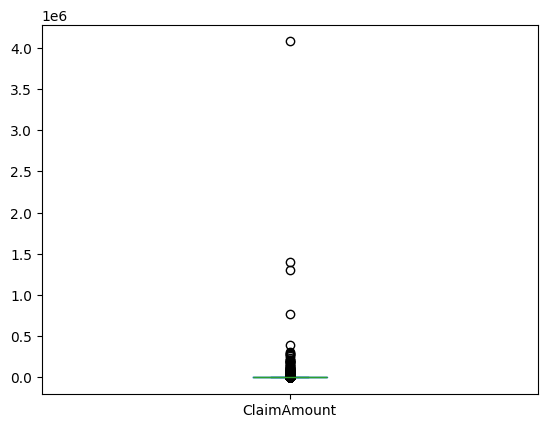

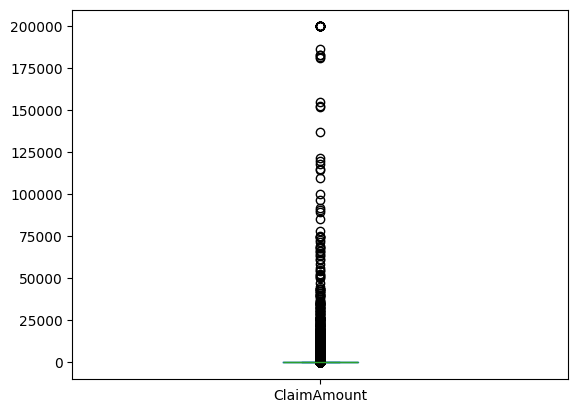

In [6]:
# 1
fig, ax = plt.subplots(1)
df_train.loc[:, 'ClaimAmount'].plot(kind='box', ax=ax)

# 2. 
df_train["ClaimAmount"] = df_train["ClaimAmount"].clip(upper=200000)
# bekijk of de waardes idd verwijderd zijn
fig2, ax2 = plt.subplots(1)
df_train.loc[:, 'ClaimAmount'].plot(kind='box', ax = ax2)

# 3
df_train["ClaimNb"] = df_train["ClaimNb"].clip(upper=4)
df_train["Exposure"] = df_train["Exposure"].clip(upper=1)


# 4 
df_train.loc[(df["ClaimAmount"] == 0) & (df_train["ClaimNb"] >= 1), "ClaimNb"] = 0


#### Antwoord Opdracht 2.2

In [7]:
display(df.loc[:, "DrivAge"].value_counts().sort_index())

mask = df_train.loc[:, "DrivAge"] < 0 
df_train.loc[mask, "DrivAge"] = np.nan

display(df_train.loc[:, "DrivAge"].value_counts().sort_index())

DrivAge
-39.0        1
-20.0        2
-10.0        1
 18.0      748
 19.0     2392
          ... 
 96.0       15
 97.0       10
 98.0        5
 99.0       70
 100.0       3
Name: count, Length: 86, dtype: int64

DrivAge
18.0      522
19.0     1708
20.0     2571
21.0     3107
22.0     3688
         ... 
96.0        9
97.0        7
98.0        3
99.0       51
100.0       3
Name: count, Length: 83, dtype: int64

#### Antwoord Opdracht 2.3


In [8]:
# missende waardes  alleen bij Driv Age
display(df_train.isna().sum())

# vul de waarde met de meest voorkomende waarde (mediaan)
# Dit omdat de missende waarde 'Missing Completely At Random zijn'. 
df_train.loc[:, "DrivAge"] = df_train.loc[:, "DrivAge"].fillna(df_train.loc[:, "DrivAge"].median())
# check dat er inderdaad geen missende waardes meer zijn
display(df_train.isna().sum())

IDpol              0
ClaimNb            0
Exposure           0
Area               0
VehPower           0
VehAge             0
DrivAge           10
BonusMalus         0
VehBrand           0
VehGas             0
Density            0
Region             0
ClaimAmount        0
PurePremium        0
Frequency          0
AvgClaimAmount     0
dtype: int64

IDpol             0
ClaimNb           0
Exposure          0
Area              0
VehPower          0
VehAge            0
DrivAge           0
BonusMalus        0
VehBrand          0
VehGas            0
Density           0
Region            0
ClaimAmount       0
PurePremium       0
Frequency         0
AvgClaimAmount    0
dtype: int64

#### Antwoord Opdracht 2.4

In [9]:
df_train.drop(columns=['IDpol'], inplace=True)

#### Antwoord. Opdracht 3.1


In [10]:
df_train = pd.get_dummies(df_train, columns=["VehGas", "VehBrand", "Area", "Region", "VehPower"])

display(df_train.sort_values('DrivAge', ascending=True))
print(df_train.dtypes)

,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,...,VehPower_6,VehPower_7,VehPower_8,VehPower_9,VehPower_10,VehPower_11,VehPower_12,VehPower_13,VehPower_14,VehPower_15
269821,0,0.47,12,18.0,100,58,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
572566,0,0.35,14,18.0,100,169,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
432183,0,0.02,1,18.0,100,119,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
290847,0,0.14,15,18.0,100,854,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
309737,0,1.00,10,18.0,50,52,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48107,0,0.33,6,99.0,81,405,0.0,0.0,0.0,0.0,...,True,False,False,False,False,False,False,False,False,False
46491,0,0.04,9,99.0,50,4128,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,False,False,False,False
650873,0,0.74,3,100.0,50,107,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False
613145,0,0.15,2,100.0,50,107,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,False,False,False,False


ClaimNb          int64
Exposure       float64
VehAge           int64
DrivAge        float64
BonusMalus       int64
                ...   
VehPower_11       bool
VehPower_12       bool
VehPower_13       bool
VehPower_14       bool
VehPower_15       bool
Length: 63, dtype: object


#### Antwoord. Opdracht 3.2

In [11]:
# df_encoded["Density_clipped"] = df_encoded["Density"].clip(lower=1e-3)  # kleine of nulwaarden voorkomen
# df_encoded.loc[:, "Density_log"] = np.log(df_encoded[["Density_clipped"]].to_numpy())
# df_encoded = df_encoded.drop(columns=["Density_clipped", "Density"])

# Density kan varieren tussen 0.1 en 50.000 - na de log is dat nog ongeveer tussen -2.3 en 10.8 --> 
# Dat is nog steeds een te grote stddeviatie - dus het is beter om deze waarde nog te scalen.

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
# Log + scaling transformer
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log, validate=True),
    StandardScaler()
)

# Fit en transformeer de kolom 'Density'
df_train['Density_log_scaled'] = log_scale_transformer.fit_transform(df_train[['Density']])
df_train.drop(columns=['Density'], inplace=True)

#### Antwoord: Opdracht 3.3 


In [12]:
# Met retbins=True zorg je dat ook de numerieke grenzen van je bins worden teruggegeven als een numpy array. 
# deze waarde sla je op in de variabelen bins_vehage & bins_drivage. 
# Deze kunnen we later gebruiken om op de test set exact dezelfde bins te gebruiken.
df_train['VehAge_bin'], bins_vehage = pd.qcut(df_train['VehAge'], q=10, duplicates='drop', retbins=True)
df_train['DrivAge_bin'], bins_drivage = pd.qcut(df_train['DrivAge'], q=10, duplicates='drop', retbins=True)
df_train = pd.get_dummies(df_train, columns=["VehAge_bin", "DrivAge_bin"])

display(df_train)



,ClaimNb,Exposure,VehAge,DrivAge,BonusMalus,ClaimAmount,PurePremium,Frequency,AvgClaimAmount,VehGas_Diesel,...,"DrivAge_bin_(17.999, 28.0]","DrivAge_bin_(28.0, 32.0]","DrivAge_bin_(32.0, 36.0]","DrivAge_bin_(36.0, 40.0]","DrivAge_bin_(40.0, 44.0]","DrivAge_bin_(44.0, 48.0]","DrivAge_bin_(48.0, 53.0]","DrivAge_bin_(53.0, 57.0]","DrivAge_bin_(57.0, 65.0]","DrivAge_bin_(65.0, 100.0]"
326390,0,0.40,0,71.0,50,0.00,0.000000,0.000000,0.00,False,...,False,False,False,False,False,False,False,False,False,True
22175,1,0.41,8,49.0,50,253.73,618.853659,2.439024,253.73,True,...,False,False,False,False,False,False,True,False,False,False
216889,0,0.46,10,67.0,62,0.00,0.000000,0.000000,0.00,False,...,False,False,False,False,False,False,False,False,False,True
289285,0,0.65,10,20.0,50,0.00,0.000000,0.000000,0.00,True,...,True,False,False,False,False,False,False,False,False,False
174976,0,0.08,1,52.0,55,0.00,0.000000,0.000000,0.00,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,0,0.08,6,30.0,76,0.00,0.000000,0.000000,0.00,True,...,False,True,False,False,False,False,False,False,False,False
152315,0,0.06,20,21.0,95,0.00,0.000000,0.000000,0.00,False,...,True,False,False,False,False,False,False,False,False,False
117952,0,0.24,0,43.0,50,0.00,0.000000,0.000000,0.00,False,...,False,False,False,False,True,False,False,False,False,False
435829,0,0.44,4,27.0,80,0.00,0.000000,0.000000,0.00,False,...,True,False,False,False,False,False,False,False,False,False


#### Antwoord: Opdracht 4.1

In [13]:
# Herhaal alle stappen, maar wees je ervan bewust dat je alle berekenden waardes
# uit je train_set moet gebruiken op je test set

# zelfde limieten zetten
df_test["ClaimAmount"] = df_test["ClaimAmount"].clip(upper=200000)
df_test["ClaimNb"] = df_test["ClaimNb"].clip(upper=4)
df_test["Exposure"] = df_test["Exposure"].clip(upper=1)
df_test.loc[(df["ClaimAmount"] == 0) & (df_test["ClaimNb"] >= 1), "ClaimNb"] = 0

# zelfde mask gebruiken als op de train set
mask = df_test.loc[:, "DrivAge"] < 0 
df_test.loc[mask, "DrivAge"] = np.nan

# LET OP: Gebruik de mediaan van df_train, NIET die van df_test.
df_test.loc[:, "DrivAge"] = df_test.loc[:, "DrivAge"].fillna(df_train.loc[:, "DrivAge"].median())

df_test.drop(columns=['IDpol'], inplace=True)

# LET OP: Density aanpassen: gebruik de al gefitte scaler van je train set --> fit niet opnieuw!
df_test['Density_log_scaled'] = log_scale_transformer.transform(df_test[['Density']])
df_test.drop(columns=['Density'], inplace=True)

# LET OP: Gebruik hier de bins zoals ze zijn afgeleid uit je trainset! Leidt ze niet opnieuw af!
# Je kunt je eerder gedefinieerde bins meegeven. Gebruik daarom pd.cut ipv pd.qcut
df_test['VehAge_bin'] = pd.cut(
    df_test['VehAge'], bins=bins_vehage, include_lowest=True
)
df_test['DrivAge_bin'] = pd.cut(df_test['DrivAge'], bins=bins_drivage)
# LET OP: Je wilt precies dezelfde kolommen als degenen die in de trainingsset voorkwamen na de one-hot-encoding
# Als er waardes niet in de test set zitten die wel in de trainingsset zaten --> voeg die kolommen toe met False of 0 waarde
# Als er waardes in de test set zitten die Niet in de trainingsset zaten --> negeer/verwijder die kolommen.
df_test_dummies = pd.get_dummies(df_test, columns=["VehGas", "VehBrand", "Area", "Region", "VehPower", "VehAge_bin", "DrivAge_bin"])
# Voeg kolommen toe die in train_set zitten maar niet in test_set
for col in df_train.columns:
    if col not in df_test_dummies.columns:
        df_test_dummies[col] = False
# verwijder extra kolommen die alleen in test-set zitten & zet ze in dezelfde volgorde
df_test_dummies = df_test_dummies[df_train.columns]
# Vervang df_test door de correcte dataframe
df_test = df_test_dummies



#### Antwoord: Opdracht 4.2

In [14]:
df_test.to_csv(r'.\Data\test_set.csv', index=False)
df_train.to_csv(r'.\Data\train_set.csv', index=False)

KeyboardInterrupt: 

### Antwoord: Een andere aanpak:

In plaats van de pandas bewerkingen, kun je ook direct gebruik maken van een cleaning-pipeline met sklearn die vanuit numpy werkt. 
In dat geval zou je de bewerkingen zo kunnen doen:



In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_tweedie_deviance,
)

# Data opschonen nog steeds met pandas
df = pd.read_csv(r'.\Data\french_car_claim_set_big.csv')

df.dropna(inplace=True)

df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)
# If the claim amount is 0, then we do not count it as a claim. The loss function
# used by the severity model needs strictly positive claim amounts. This way
# frequency and severity are more consistent with each other.
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0


# Met omzetten naar extra kolommen, bins en log & scaling via de ColumnTansformer.
log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        (
            "binned_numeric",
            KBinsDiscretizer(
                n_bins=10, quantile_method="averaged_inverted_cdf", random_state=0
            ),
            ["VehAge", "DrivAge"],
        ),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# Dit geeft een compressed matrix terug die je gelijk in je optimalisatie kunt stoppen.
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6102054 stored elements and shape (678006, 75)>